In [21]:
import pandas as pd
data_less_null = pd.read_csv('compounds_with_safety_processed.csv')

In [30]:
data_less_null

,compound_name,clinical_phase,mechanism_of_action,cf_max_score,cf_avg_score,cf_top_pose,docking_max_score,docking_avg_score,docking_top_pose,safety_Aurora kinase A,...,chem_slogp_vsa5,chem_slogp_vsa7,chem_slogp_vsa9,chem_smr_vsa0,chem_smr_vsa2,chem_smr_vsa4,chem_smr_vsa6,chem_tpsa,cv_safety_score,high_potential
0,lersivirine,Phase 2,non-nucleoside reverse transcriptase inhibitor,6.29,5.747,5.87,-5.2,-5.45,-5.6,4.35,...,37.74,52.93,95.58,0.00,0.00,0.00,20.93,94.86,5.670,0
1,radafaxine,Phase 2,dopamine-norepinephrine reuptake inhibitor,6.81,5.670,5.27,-4.9,-5.08,-5.5,5.40,...,0.00,70.57,139.13,11.00,0.00,0.00,20.93,46.07,5.695,0
2,telcagepant,Phase 3,calcitonin antagonist,6.12,5.429,5.04,-5.4,-5.66,-6.1,5.65,...,0.00,105.43,127.61,71.59,47.14,23.10,88.68,97.88,5.770,0
3,benzenemethanol,Preclinical,NaN,6.78,5.522,5.67,-4.2,-4.49,-4.8,4.52,...,0.00,52.93,133.30,0.00,0.00,0.00,18.44,36.84,5.125,0
4,mitoxantrone,Launched,topoisomerase inhibitor,6.09,5.593,5.88,-4.8,-4.89,-5.2,5.78,...,0.00,70.57,10.76,90.41,0.00,41.53,163.87,175.17,4.895,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6368,clofedanol,Launched,histamine receptor antagonist,6.49,5.661,6.00,-4.9,-5.07,-5.5,5.51,...,65.79,158.79,39.15,3.12,0.00,0.00,18.44,24.67,5.500,0
6369,Debio-0932,Phase 1,HSP inhibitor,6.78,5.252,4.40,-4.6,-4.74,-4.9,5.91,...,68.04,74.43,166.21,16.79,5.37,9.37,59.86,96.29,6.280,0
6370,eptifibatide,Launched,platelet aggregation inhibitor,5.84,1.152,5.84,0.0,-1.24,-6.8,6.38,...,18.87,92.50,60.36,233.58,124.85,70.51,129.96,328.46,4.550,0
6371,Y-27152,Phase 1,potassium channel activator,7.22,6.301,6.32,-5.7,-5.88,-6.2,5.86,...,0.00,141.15,126.15,35.08,0.00,0.00,5.26,82.79,5.515,0


In [23]:
compound_list = [
    "andarine", "AZD2461", "BMS-906024", "candesartan", "CPI-0610", "cycloheximide",
    "dienogest", "epinastine", "evodiamine", "hypericin", "I-BRD9", "ilaprazole",
    "indiplon", "INT-767", "ITX3", "K-strophanthidin", "L-701324", "LY2183240",
    "MK-1064", "monensin", "narasin", "navarixin", "obeticholic-acid",
    "olmesartan-medoxomil", "palmatine-chloride", "perfluorodecalin",
    "PF-04217903", "PF-477736", "PIK-293", "resmetirom", "RU-28318",
    "sanguinarium-chloride", "SCH-58261", "SP-100030", "SPP86", "sulfinpyrazone",
    "sulindac", "TAK-063", "TC-S-7009", "TEPP-46", "tivantinib"
]

data_less_null['high_potential'] = data_less_null['compound_name'].isin(compound_list).astype(int)

# Display the count of high potential vs non-high potential compounds to verify


In [24]:
data_less_null['high_potential'].value_counts()

high_potential
0    6332
1      41
Name: count, dtype: int64

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('randomforest', RandomForestClassifier(random_state=42, n_estimators=100))
])

In [26]:
n_splits = 5 # You can adjust the number of splits
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [27]:
from sklearn.impute import KNNImputer
data_numerical = data_less_null.select_dtypes(include=['float64', 'int64'])
imputer = KNNImputer(n_neighbors=15)
data_numerical = pd.DataFrame(imputer.fit_transform(data_numerical), columns=data_numerical.columns)

X = data_numerical.drop(columns=['high_potential'])
y = data_numerical['high_potential']

In [28]:
all_y_true = []
all_y_pred = []
all_y_proba = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    print("Training class distribution:")
    print(y_train.value_counts())
    print("Testing class distribution:")
    print(y_test.value_counts())
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_proba.extend(y_proba)

    print("\nClassification Report (Fold {}):".format(fold+1))
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix (Fold {}):".format(fold+1))
    print(confusion_matrix(y_test, y_pred))
    print("Accuracy (Fold {}): {:.4f}".format(fold+1, accuracy_score(y_test, y_pred)))
    try:
        from sklearn.metrics import roc_auc_score
        auc_roc = roc_auc_score(y_test, y_proba)
        print("AUC-ROC (Fold {}): {:.4f}".format(fold+1, auc_roc))
    except ValueError:
        print("AUC-ROC (Fold {}): Not applicable (only one class present in y_true_proba)".format(fold+1))


print("\n" + "=" * 30)
print("Overall Performance Across All Folds:")
print(classification_report(all_y_true, all_y_pred, zero_division=0))
print("Confusion Matrix (Overall):")
print(confusion_matrix(all_y_true, all_y_pred))
print("Overall Accuracy: {:.4f}".format(accuracy_score(all_y_true, all_y_pred)))
try:
    from sklearn.metrics import roc_auc_score, f1_score
    overall_auc_roc = roc_auc_score(all_y_true, all_y_proba)
    print("Overall AUC-ROC: {:.4f}".format(overall_auc_roc))
except ValueError:
    print("Overall AUC-ROC: Not applicable (only one class present in overall y_true_proba)")

overall_f1_minority = f1_score(all_y_true, all_y_pred, pos_label=1, zero_division=0)
print(f"Overall F1-Score (Minority Class 1): {overall_f1_minority:.4f}")


--- Fold 1/5 ---
Training class distribution:
high_potential
0.0    5065
1.0      33
Name: count, dtype: int64
Testing class distribution:
high_potential
0.0    1267
1.0       8
Name: count, dtype: int64

Classification Report (Fold 1):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1267
         1.0       0.50      0.25      0.33         8

    accuracy                           0.99      1275
   macro avg       0.75      0.62      0.67      1275
weighted avg       0.99      0.99      0.99      1275

Confusion Matrix (Fold 1):
[[1265    2]
 [   6    2]]
Accuracy (Fold 1): 0.9937
AUC-ROC (Fold 1): 0.9874

--- Fold 2/5 ---
Training class distribution:
high_potential
0.0    5065
1.0      33
Name: count, dtype: int64
Testing class distribution:
high_potential
0.0    1267
1.0       8
Name: count, dtype: int64

Classification Report (Fold 2):
              precision    recall  f1-score   support

         0.0       1.00      1.00    

# Model improvement

In [32]:
from sklearn.impute import KNNImputer
clinical_phase = data_less_null['clinical_phase']
data_numerical = data_less_null.select_dtypes(include=['float64', 'int64'])
data_numerical['clinical_phase'] = clinical_phase
data_numerical = pd.get_dummies(data_numerical, columns=['clinical_phase'], drop_first=True)
imputer = KNNImputer(n_neighbors=15)
data_numerical = pd.DataFrame(imputer.fit_transform(data_numerical), columns=data_numerical.columns)

X = data_numerical.drop(columns=['high_potential'])
y = data_numerical['high_potential']

Original class distribution:
high_potential
0.0    6332
1.0      41
Name: count, dtype: int64
------------------------------
Features in X (all numerical, imputed, with clinical_phase encoded): ['cf_max_score', 'cf_avg_score', 'cf_top_pose', 'docking_max_score', 'docking_avg_score']... (57 total)
------------------------------

Performing Randomized Search for Hyperparameter Tuning (Random Forest on pre-processed data)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END randomforest__class_weight=None, randomforest__max_depth=38, randomforest__max_features=0.5, randomforest__min_samples_leaf=3, randomforest__min_samples_split=9, randomforest__n_estimators=900, smote__k_neighbors=6, smote__sampling_strategy=0.25; total time=  29.7s
[CV] END randomforest__class_weight=None, randomforest__max_depth=38, randomforest__max_features=0.5, randomforest__min_samples_leaf=3, randomforest__min_samples_split=9, randomforest__n_estimators=900, smote__k_neighbors=6, smote__samplin

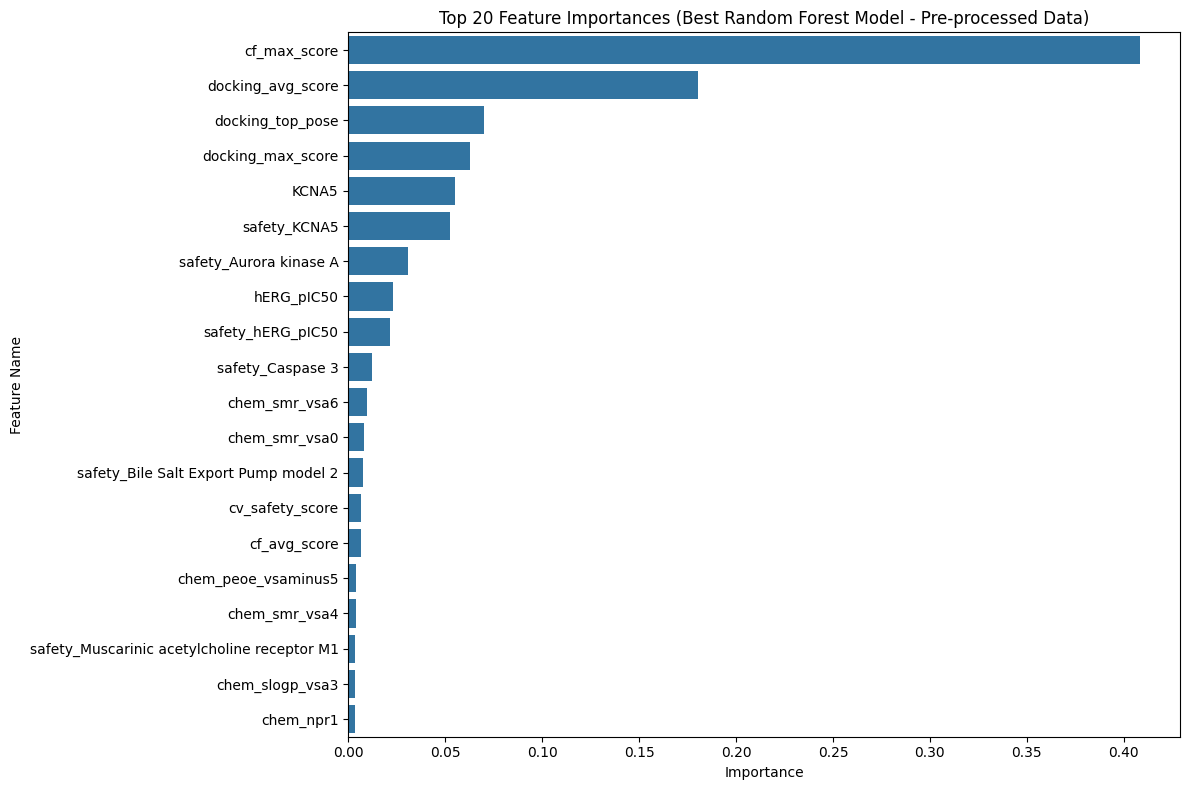

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler # Still need StandardScaler for numerical features
from sklearn.impute import KNNImputer # You're using this outside the pipeline
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import seaborn as sns

print("Original class distribution:")
print(y.value_counts())
print("-" * 30)

# The numerical_cols here are simply all columns in X, as it's already pre-processed
numerical_cols = X.columns.tolist()

print(f"Features in X (all numerical, imputed, with clinical_phase encoded): {numerical_cols[:5]}... ({len(numerical_cols)} total)")
print("-" * 30)

# --- 3. Define the Pipeline (SIMPLIFIED!) ---
# No ColumnTransformer needed, as X is already fully numerical.
# No Imputer needed, as KNNImputer was already applied outside.
pipeline = Pipeline([
    ('scaler', StandardScaler()), # Scale numerical features
    ('smote', SMOTE(random_state=42)), # Oversample minority class
    ('randomforest', RandomForestClassifier(random_state=42)) # Random Forest Classifier
])

# --- 4. Define the Parameter Grid for RandomizedSearchCV ---
param_distributions = {
    # SMOTE parameters
    'smote__k_neighbors': randint(2, 10),
    'smote__sampling_strategy': [0.1, 0.25, 0.5, 0.75, 1.0, 'not majority'],

    # RandomForestClassifier parameters
    'randomforest__n_estimators': randint(200, 1000),
    'randomforest__max_depth': randint(10, 50),
    'randomforest__min_samples_split': randint(2, 10),
    'randomforest__min_samples_leaf': randint(1, 5),
    'randomforest__max_features': ['sqrt', 'log2', 0.5, 0.7],
    'randomforest__class_weight': ['balanced', 'balanced_subsample', None]
}

# --- 5. Set up Cross-Validation ---
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

f1_scorer_minority = make_scorer(f1_score, pos_label=1, zero_division=0)

# --- 6. Perform RandomizedSearchCV ---
print("\nPerforming Randomized Search for Hyperparameter Tuning (Random Forest on pre-processed data)...")
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5, # Number of parameter settings sampled. Increase for more thorough search.
    cv=skf,
    scoring=f1_scorer_minority, # Optimize for F1-score of minority class
    verbose=2, # Prints progress
    random_state=42,
    n_jobs=-1 # Use all available CPU cores
)

# Fit RandomizedSearchCV on your already prepared X and y
random_search.fit(X, y)

print("\n" + "=" * 50)
print("RandomizedSearchCV Results:")
print("Best Parameters found: ", random_search.best_params_)
print("Best F1-Score (Minority Class) found: {:.4f}".format(random_search.best_score_))
print("=" * 50)

# --- 7. Final Model Evaluation with Best Estimator ---
print("\nEvaluating the best model from RandomizedSearchCV using cross-validation...")
best_pipeline = random_search.best_estimator_

all_y_true_best = []
all_y_pred_best = []
all_y_proba_best = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(f"\n--- Best Model Fold {fold+1}/{n_splits} ---")
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]

    all_y_true_best.extend(y_test)
    all_y_pred_best.extend(y_pred)
    all_y_proba_best.extend(y_proba)

    print("Classification Report (Fold {}):".format(fold+1))
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix (Fold {}):".format(fold+1))
    print(confusion_matrix(y_test, y_pred))
    try:
        auc_roc = roc_auc_score(y_test, y_proba)
        print("AUC-ROC (Fold {}): {:.4f}".format(fold+1, auc_roc))
    except ValueError:
        pass

print("\n" + "=" * 50)
print("Overall Performance of Best Model from RandomizedSearchCV:")
print(classification_report(all_y_true_best, all_y_pred_best, zero_division=0))
print("Confusion Matrix (Overall):")
print(confusion_matrix(all_y_true_best, all_y_pred_best))
print("Overall Accuracy: {:.4f}".format(accuracy_score(all_y_true_best, all_y_pred_best)))
try:
    overall_auc_roc_best = roc_auc_score(all_y_true_best, all_y_proba_best)
    print("Overall AUC-ROC: {:.4f}".format(overall_auc_roc_best))
except ValueError:
    pass
overall_f1_minority_best = f1_score(all_y_true_best, all_y_pred_best, pos_label=1, zero_division=0)
print(f"Overall F1-Score (Minority Class 1): {overall_f1_minority_best:.4f}")
print("=" * 50)


# --- 8. Feature Importance for the Best Random Forest Model ---
print("\n" + "=" * 50)
print("Extracting Feature Importances for the Best Random Forest Model...")

best_pipeline.fit(X, y) # Ensure the pipeline is fit on the full X

rf_model_best = best_pipeline.named_steps['randomforest']
importances = rf_model_best.feature_importances_

# Feature names are simply the columns of X, as no more encoding happens in the pipeline
feature_names_out = X.columns.tolist()

feature_importance_df_best_rf = pd.DataFrame({
    'Feature': feature_names_out,
    'Importance': importances
})

feature_importance_df_best_rf = feature_importance_df_best_rf.sort_values(by='Importance', ascending=False)

print("\nTop 20 Feature Importances (Best Random Forest Model):")
print(feature_importance_df_best_rf.head(20))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_best_rf.head(20))
plt.title('Top 20 Feature Importances (Best Random Forest Model - Pre-processed Data)')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()